# mini BERT 

vocab size = 8000  
params = 1M 

### 루브릭 
1. 한글 코퍼스를 가공하여 BERT pretrain용 데이터셋을 잘 생성하였다.  
    ```text
    100%|██████████| 128000/128000 [00:28<00:00, 4492.42it/s]
    data load early stop 128000 128000
    ```
2. 구현한 BERT 모델의 학습이 안정적으로 진행됨을 확인하였다.  

3. 1M짜리 mini BERT 모델의 제작과 학습이 정상적으로 진행되었다.

In [2]:
import copy
import json
import math
import random
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sentencepiece as sp

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [3]:
# sentence piece 파라미터
vocab_size = 8000
path_file = "data/kowiki.txt"

In [4]:
# sentence piece 훈련
# 중복훈련 방지를 위해 주석
# sp.SentencePieceTrainer.Train(
#     "--input={} --model_prefix=korean_spm --vocab_size={} --model_type=bpe \
#     --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] \
#     --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]".format(
#         path_file, vocab_size + 7
#     )
# )

In [5]:
# vocab loading
vocab = sp.SentencePieceProcessor()
vocab.load("model/korean_spm.model")

True

## MLM을 위한 마스킹

In [6]:
def create_pretrain_mask(tokens_org, mask_percent, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_percent: mask 퍼센트
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []  # word 단위의 index array
    for i, token in enumerate(tokens_org):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(
            "\u2581"
        ):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)

    # 마스킹
    tokens = copy.deepcopy(tokens_org)
    mask_cnt = int((len(tokens_org) - 3) * mask_percent)
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if (
            len(mask_lms) + len(index_set) > mask_cnt
        ):  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9:  # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

In [7]:
# 테스트
# string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
# string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
# tokens_org = (
#     ["[CLS]"]
#     + vocab.encode_as_pieces(string_a)
#     + ["[SEP]"]
#     + vocab.encode_as_pieces(string_b)
#     + ["[SEP]"]
# )
# # 특수 token 7개를 제외한 나머지 token들 집합
# vocab_list = []
# for id in range(7, len(vocab)):
#     if not vocab.is_unknown(id):
#         vocab_list.append(vocab.Decode(id))

# tokens, mask_idx, mask_label = create_pretrain_mask(tokens_org, 0.15, vocab_list)

# print("tokens_org")
# print(tokens_org, "\n")
# print("tokens")
# print(tokens, "\n")

# print("mask_idx   :", mask_idx)
# print("mask_label :", mask_label)

## NSP 페어 

In [8]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """

    def trim_tokens(tokens_a, tokens_b, max_seq):
        """
        tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
        :param tokens_a: tokens A
        :param tokens_b: tokens B
        :param max_seq: 두 tokens 길이의 최대 값
        """
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_seq:
                break

            if len(tokens_a) > len(tokens_b):
                del tokens_a[0]
            else:
                tokens_b.pop()

    # for [CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0

    # txt 데이터를 sp토크나이저로 분할 후 list로 저장
    if type(doc) is str:
        doc = [vocab.encode_as_pieces(line) for line in doc.split("\n")]

    for i in range(len(doc)):  # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        # 마지막 줄 이거나 길이가 max_seq 이상일 때 까지
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):

            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0  # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1  # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            # print("is_next:", is_next)
            # print("tokens_a:", len(tokens_a), tokens_a)
            # print("tokens_b:", len(tokens_b), tokens_b)
            #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # print("tokens:", len(tokens), tokens)
            # print("segment:", len(segment), segment)

            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(
                tokens, mask_prob, vocab_list
            )
            # print("masked tokens:", len(tokens), tokens)
            # print("masked index:", len(mask_idx), mask_idx)
            # print("masked label:", len(mask_label), mask_label)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label,
            }
            instances.append(instance)
            #######################################

            current_chunk = []
            current_length = 0
    return instances

In [9]:
# # 테스트
# string = """추적추적 비가 내리는 날이었어
#     그날은 왠지 손님이 많아
#     첫 번에 삼십 전 둘째 번 오십 전
#     오랜만에 받아보는 십 전짜리 백통화 서푼에
#     손바닥 위엔 기쁨의 눈물이 흘러
#     컬컬한 목에 모주 한잔을 적셔
#     몇 달 포 전부터 콜록거리는 아내
#     생각에 그토록 먹고 싶다던
#     설렁탕 한 그릇을 이제는 살 수 있어
#     집으로 돌아가는 길 난 문득 떠올라
#     아내의 목소리가 거칠어만 가는 희박한 숨소리가
#     오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
#     그리도 나가고 싶으면 일찍이라도 들어와 달라던
#     아내의 간절한 목소리가 들려와
#     나를 원망하듯 비는 점점 거세져
#     싸늘히 식어가는 아내가 떠올라 걱정은 더해져
#     난 몰라 오늘은 운수 좋은 날
#     난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

# n_test_seq = 64
# instances = create_pretrain_instances(vocab, string, n_test_seq, 0.15, vocab_list)

# # 최종 데이터셋 결과 확인
# for instance in instances:
#     print("tokens : ", instance["tokens"])
#     print("segment : ", instance["segment"])
#     print("is_next : ", instance["is_next"])
#     print("mask_idx : ", instance["mask_idx"])
#     print("mask_label : ", instance["mask_label"])
#     print()

## 데이터 전처리

In [10]:
# 데이터 로드
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """pretrain 데이터 생성"""

    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(
            id
        ):  # 생성되는 단어 목록이 unknown인 경우는 제거합니다.
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    # 다시 파일을 읽어서 전처리
    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt, disable=False):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)

In [11]:
# 파일 저장
path_pretrain_json = "data/bert_pre_train.json"
# make_pretrain_data(vocab, path_file, path_pretrain_json, 128)

In [12]:
# 데이터 수 확인
total = 0
with open(path_pretrain_json, "r") as f:
    for line in f:
        total += 1
total

918174

### 메모리 사용 최적화
파일이 커서 `np.memmap`을 사용해 최적화   
전체 파일을 메모리에 올리지 않고 부분적으로 적재

In [13]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(
        filename="enc_tokens.memmap", mode="w+", dtype=np.int32, shape=(total, n_seq)
    )
    segments = np.memmap(
        filename="segments.memmap", mode="w+", dtype=np.int32, shape=(total, n_seq)
    )
    labels_nsp = np.memmap(
        filename="labels_nsp.memmap", mode="w+", dtype=np.int32, shape=(total,)
    )
    labels_mlm = np.memmap(
        filename="labels_mlm.memmap", mode="w+", dtype=np.int32, shape=(total, n_seq)
    )

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=int)
            mask_label = np.array(
                [vocab.piece_to_id(p) for p in data["mask_label"]], dtype=int
            )
            label_mlm = np.full(n_seq, dtype=int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [14]:
pre_train_inputs, pre_train_labels = load_pre_train_data(
    vocab, path_pretrain_json, 128, count=128000
)

100%|██████████| 128000/128000 [00:28<00:00, 4492.42it/s]

data load early stop 128000 128000


## 모델

In [15]:
# 유틸리티 함수
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + tf.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """

    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, "r") as f:
            config = json.loads(f.read())
            return Config(config)

In [16]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """

    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model

    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer(),
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(
            outputs, [n_batch, n_seq, self.n_vocab]
        )  # (bs, n_seq, n_vocab)
        return outputs

In [17]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """

    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.embedding = tf.keras.layers.Embedding(
            config.n_seq, config.d_model, embeddings_initializer=kernel_initializer()
        )

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        # [0, 1, 2, ..., n_seq-1]
        position = tf.cast(
            tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32
        )
        embed = self.embedding(position)
        return embed

In [18]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """

    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.0e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """

    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(
            config.n_head * config.d_head,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer(),
        )
        self.W_K = tf.keras.layers.Dense(
            config.n_head * config.d_head,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer(),
        )
        self.W_V = tf.keras.layers.Dense(
            config.n_head * config.d_head,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer(),
        )
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(
            config.d_model,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer(),
        )

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(
            tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]),
            [0, 2, 1, 3],
        )  # [bs, n_head, Q_len, d_head]
        K_m = tf.transpose(
            tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]),
            [0, 2, 1, 3],
        )  # [bs, n_head, K_len, d_head]
        V_m = tf.transpose(
            tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]),
            [0, 2, 1, 3],
        )  # [bs, n_head, K_len, d_head]
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)

        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(
            Q_m, K_m, V_m, attn_mask_m
        )  # [bs, n_head, Q_len, d_head]

        # transpose and liner
        attn_out = tf.transpose(attn_out, [0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)

        attn_out = tf.reshape(
            attn_out, (batch_size, -1, self.d_model)
        )  # (bs, Q_len, d_model)

        attn_out = self.W_O(attn_out)  # (bs, Q_len, d_model)

        return attn_out

In [20]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """

    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(
            config.d_ff,
            activation=gelu,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer(),
        )
        self.W_2 = tf.keras.layers.Dense(
            config.d_model,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer(),
        )

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """

    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(
            epsilon=config.layernorm_epsilon
        )

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(
            epsilon=config.layernorm_epsilon
        )

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [22]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """

    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(
            2, config.d_model, embeddings_initializer=kernel_initializer()
        )
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.encoder_layers = [
            EncoderLayer(config, name=f"encoder_layer_{i}")
            for i in range(config.n_layer)
        ]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(
            get_pad_mask, output_shape=(1, None), name="enc_self_mask"
        )(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:, 0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [23]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(
            config.d_model,
            activation=tf.nn.tanh,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer(),
        )
        self.dense2 = tf.keras.layers.Dense(
            n_output,
            use_bias=False,
            activation=tf.nn.softmax,
            name="nsp",
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer(),
        )

    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [24]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(
        inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm)
    )
    return model

In [47]:
config = Config(
    {
        "d_model": 128,
        "n_head": 4,
        "d_head": 32,
        "dropout": 0.1,
        "d_ff": 512,
        "layernorm_epsilon": 0.001,
        "n_layer": 3,
        "n_seq": 256,
        "n_vocab": 0,
        "i_pad": 0,
    }
)
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 128,
 'n_head': 4,
 'd_head': 32,
 'dropout': 0.1,
 'd_ff': 512,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

## 학습

In [26]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        reduction=tf.keras.losses.Reduction.NONE
    )(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

In [27]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [28]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """

    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(
            1, self.train_steps - self.warmup_steps
        )
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

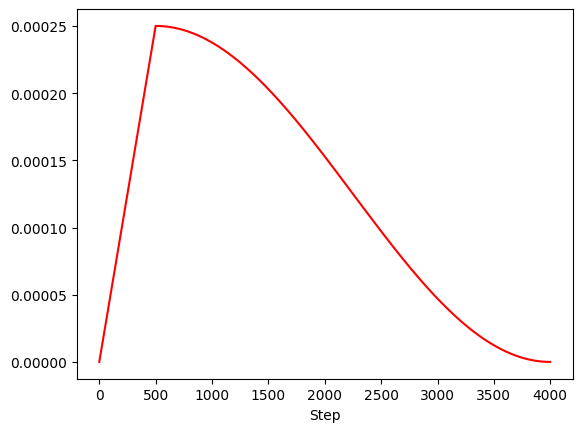

In [29]:
# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, "r-", label="learning_rate")
plt.xlabel("Step")
plt.show()

In [48]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 128),        1652992     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                            

In [49]:
epochs = 30
batch_size = 128

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(
    train_steps=train_steps, warmup_steps=max(100, train_steps // 10)
)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

# compile
pre_train_model.compile(
    loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss),
    optimizer=optimizer,
    metrics={"nsp": "acc", "mlm": lm_acc},
)

train_steps: 30000


In [50]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(
    "model/bert_pre_train.hdf5",
    monitor="mlm_lm_acc",
    verbose=1,
    save_best_only=True,
    mode="max",
    save_freq="epoch",
    save_weights_only=True,
)
early_stop = tf.keras.callbacks.EarlyStopping("val_loss", patience=3)
# train
history = pre_train_model.fit(
    pre_train_inputs,
    pre_train_labels,
    batch_size,
    epochs,
    callbacks=[save_weights, early_stop],
    validation_split=0.2,
)

Epoch 1/30
800/800 [==============================] - ETA: 0s - loss: 22.2932 - nsp_loss: 0.6885 - mlm_loss: 21.6047 - nsp_acc: 0.5283 - mlm_lm_acc: 0.0565
Epoch 1: mlm_lm_acc improved from -inf to 0.05654, saving model to model\bert_pre_train.hdf5
800/800 [==============================] - 62s 74ms/step - loss: 22.2932 - nsp_loss: 0.6885 - mlm_loss: 21.6047 - nsp_acc: 0.5283 - mlm_lm_acc: 0.0565 - val_loss: 19.7293 - val_nsp_loss: 0.6372 - val_mlm_loss: 19.0921 - val_nsp_acc: 0.6174 - val_mlm_lm_acc: 0.0391
Epoch 2/30
800/800 [==============================] - ETA: 0s - loss: 19.6815 - nsp_loss: 0.6481 - mlm_loss: 19.0334 - nsp_acc: 0.5930 - mlm_lm_acc: 0.0465
Epoch 2: mlm_lm_acc did not improve from 0.05654
800/800 [==============================] - 58s 73ms/step - loss: 19.6815 - nsp_loss: 0.6481 - mlm_loss: 19.0334 - nsp_acc: 0.5930 - mlm_lm_acc: 0.0465 - val_loss: 19.0633 - val_nsp_loss: 0.6247 - val_mlm_loss: 18.4386 - val_nsp_acc: 0.6230 - val_mlm_lm_acc: 0.0656
Epoch 3/30
800/8

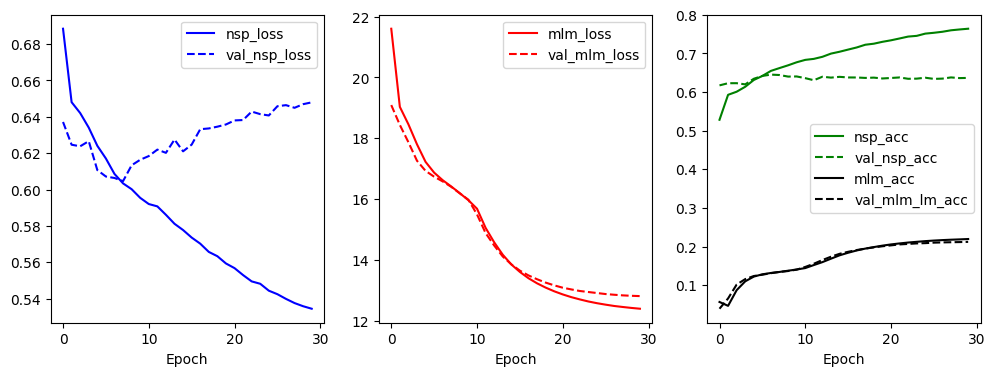

In [51]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history["nsp_loss"], "b-", label="nsp_loss")
plt.plot(history.history["val_nsp_loss"], "b--", label="val_nsp_loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history["mlm_loss"], "r-", label="mlm_loss")
plt.plot(history.history["val_mlm_loss"], "r--", label="val_mlm_loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history["nsp_acc"], "g-", label="nsp_acc")
plt.plot(history.history["val_nsp_acc"], "g--", label="val_nsp_acc")
plt.plot(history.history["mlm_lm_acc"], "k-", label="mlm_acc")
plt.plot(history.history["val_mlm_lm_acc"], "k--", label="val_mlm_lm_acc")
plt.xlabel("Epoch")
plt.legend()

plt.show()

### 더 큰 모델
loss가 잘 떨어지지 않아서 큰 모델로 학습

In [53]:
config_big = Config(
    {
        "d_model": 512,
        "n_head": 8,
        "d_head": 64,
        "dropout": 0.1,
        "d_ff": 1024,
        "layernorm_epsilon": 0.001,
        "n_layer": 4,
        "n_seq": 256,
        "n_vocab": len(vocab),
        "i_pad": vocab.pad_id(),
    }
)
# 빌드
pre_train_model_big = build_model_pre_train(config_big)
pre_train_model_big.summary()
pre_train_model_big.compile(
    loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss),
    optimizer=optimizer,
    metrics={"nsp": "acc", "mlm": lm_acc},
)
save_weights_big = tf.keras.callbacks.ModelCheckpoint(
    "model/bert_pre_train_big.hdf5",
    monitor="mlm_lm_acc",
    verbose=1,
    save_best_only=True,
    mode="max",
    save_freq="epoch",
    save_weights_only=True,
)
# train
history_big = pre_train_model_big.fit(
    pre_train_inputs,
    pre_train_labels,
    batch_size,
    epochs,
    callbacks=[save_weights_big, early_stop],
    validation_split=0.2,
)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 512),        12643840    ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                            

시각화

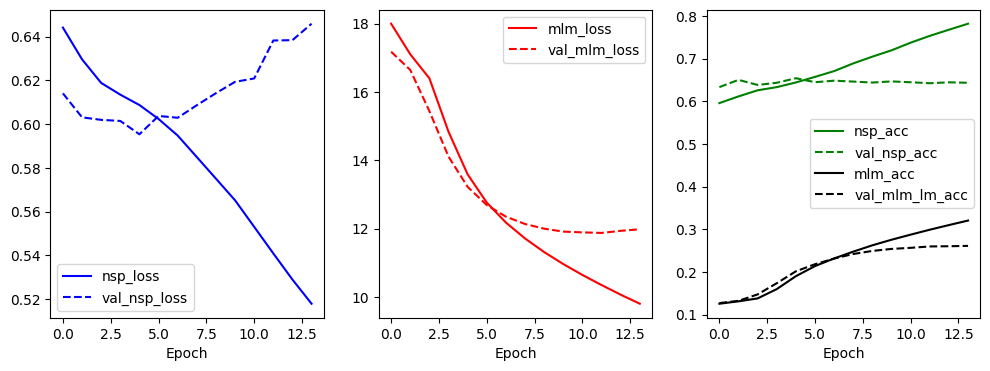

In [54]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history_big.history["nsp_loss"], "b-", label="nsp_loss")
plt.plot(history_big.history["val_nsp_loss"], "b--", label="val_nsp_loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_big.history["mlm_loss"], "r-", label="mlm_loss")
plt.plot(history_big.history["val_mlm_loss"], "r--", label="val_mlm_loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_big.history["nsp_acc"], "g-", label="nsp_acc")
plt.plot(history_big.history["val_nsp_acc"], "g--", label="val_nsp_acc")
plt.plot(history_big.history["mlm_lm_acc"], "k-", label="mlm_acc")
plt.plot(history_big.history["val_mlm_lm_acc"], "k--", label="val_mlm_lm_acc")
plt.xlabel("Epoch")
plt.legend()

plt.show()

오버피팅 고려 안하고 계속 epoch 증가

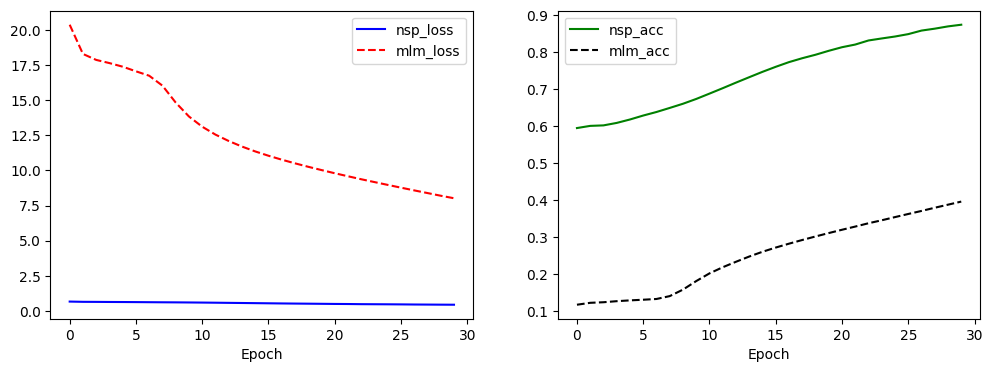

In [39]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history_big.history["nsp_loss"], "b-", label="nsp_loss")
plt.plot(history_big.history["val_nsp_loss"], "b--", label="val_nsp_loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_big.history["mlm_loss"], "r-", label="mlm_loss")
plt.plot(history_big.history["val_mlm_loss"], "r--", label="val_mlm_loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_big.history["nsp_acc"], "g-", label="nsp_acc")
plt.plot(history_big.history["val_nsp_acc"], "g--", label="val_nsp_acc")
plt.plot(history_big.history["mlm_lm_acc"], "k-", label="mlm_acc")
plt.plot(history_big.history["val_mlm_lm_acc"], "k--", label="val_mlm_lm_acc")
plt.xlabel("Epoch")
plt.legend()

plt.show()

충분히 loss 감소가 더 진행 될 거 같아서 epoch를 추가

In [40]:
additional_epoch = 20
history_big = pre_train_model_big.fit(
    pre_train_inputs,
    pre_train_labels,
    batch_size,
    epochs + additional_epoch,
    initial_epoch=epochs,
    callbacks=[save_weights_big, early_stop],
)

Epoch 31/50
1000/1000 [==============================] - ETA: 0s - loss: 8.2602 - nsp_loss: 0.4293 - mlm_loss: 7.8309 - nsp_acc: 0.8796 - mlm_lm_acc: 0.4049
Epoch 31: mlm_lm_acc improved from 0.39622 to 0.40491, saving model to model\bert_pre_train.hdf5
1000/1000 [==============================] - 184s 184ms/step - loss: 8.2602 - nsp_loss: 0.4293 - mlm_loss: 7.8309 - nsp_acc: 0.8796 - mlm_lm_acc: 0.4049
Epoch 32/50
1000/1000 [==============================] - ETA: 0s - loss: 8.0740 - nsp_loss: 0.4249 - mlm_loss: 7.6491 - nsp_acc: 0.8838 - mlm_lm_acc: 0.4135
Epoch 32: mlm_lm_acc improved from 0.40491 to 0.41352, saving model to model\bert_pre_train.hdf5
1000/1000 [==============================] - 183s 183ms/step - loss: 8.0740 - nsp_loss: 0.4249 - mlm_loss: 7.6491 - nsp_acc: 0.8838 - mlm_lm_acc: 0.4135
Epoch 33/50
1000/1000 [==============================] - ETA: 0s - loss: 7.8885 - nsp_loss: 0.4193 - mlm_loss: 7.4692 - nsp_acc: 0.8904 - mlm_lm_acc: 0.4223
Epoch 33: mlm_lm_acc improved

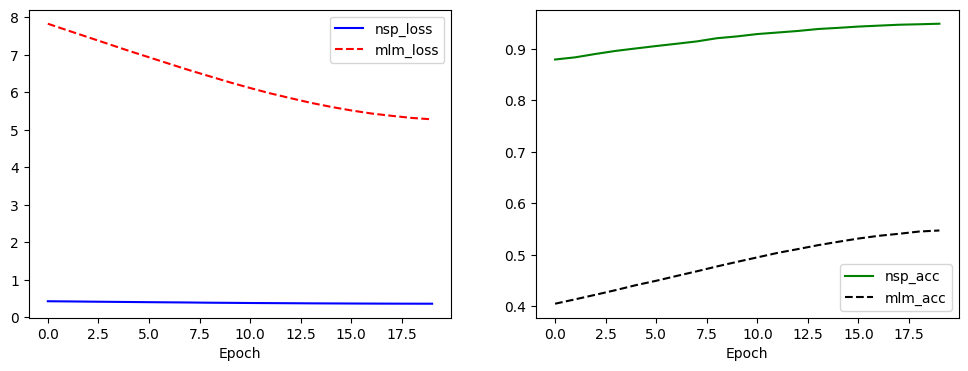

In [41]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_big.history["nsp_loss"], "b-", label="nsp_loss")
plt.plot(history_big.history["mlm_loss"], "r--", label="mlm_loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_big.history["nsp_acc"], "g-", label="nsp_acc")
plt.plot(history_big.history["mlm_lm_acc"], "k--", label="mlm_acc")
plt.xlabel("Epoch")
plt.legend()

plt.show()

## 결론 및 회고

프로젝트 요구사항에 맞추어 1M정도의 작은 모델은  
`loss: 13.1772 - nsp_loss: 0.5596 - mlm_loss: 12.6175 - nsp_acc: 0.7301 - mlm_lm_acc: 0.2107`   
정도의 성능이 나왔다. epoch를 30번이나 돌렸는데, loss의 감소 추이를 보면 12 이하로 떨어질 거 같지 않았다. 
또한 valid 세트를 추가하여 보니 epoch 10부터 nsp태스크에서 오버피팅이 발생하였다. 

그래서 모델 규모를 10배 정도 키운 13M정도의 모델로 학습을 하였는데, 확실히 학습이 잘 되었다. 
모델이 커짐과 동시에 epoch도 훨씬 많이 필요했었다. 
50 epoch에서  
`loss: 5.6441 - nsp_loss: 0.3633 - mlm_loss: 5.2808 - nsp_acc: 0.9491 - mlm_lm_acc: 0.5473`
정도의 성능이 나왔지만, 오버피팅을 생각하면 금방 학습이 중단되었다. 오버피팅을 고려하지 않더라도 loss가 아직 크고, mlm정확도도 낮게 나와서 더 큰 규모의 모델이 필요할 것 같다라는 결론을 얻게 되었다. 
nlp가 왜 규모를 확장하는 방향으로 발전했는지 잘 알 수 있었다. 

오버피팅 문제는 일반화의 문제이니 데이터를 늘리면 많이 해결이 될 거 같았다. 사용한 데이터가 wiki데이터의 일부이고 단어사전 크기도 작기 때문에, 위키 주제가 달라지면 사용되는 단어가 많이 달라지니까 이런 문제가 있을 것 같았다. 위키의 데이터를 랜덤하게 valid로 쓰려면 모델이 매우 넓은 범위의 주제를 전부 커버할 수 있어야 하는데 그러기 위해서는 이정도 데이터로는 부족한 것 같았다.  

그래서 이러한 조건에서는 차라리 오버피팅을 고려하지 않고, 모델의 규모에 따라 어디까지 학습이 가능한 지를 보는 게 더 의미있을 것 같아서 50epoch까지 돌려보았고 mlm문제 해결을 점점 잘해지는 것을 확인해 보았다.  

트랜스포머를 해본 상황에서는 bert자체는 데이터를 어떻게 구성하는 가가 프로젝트의 핵심이었고, 
사실 fine tuning을 하지 않았지만 이 역시 데이터를 구성하는 것이 가장 중요할 것 같았다.  

이번에는 90만개의 데이터 중에 12만 8천개 정도만 사용했는데, 모든 데이터를 사용하면 더 좋은 결과가 나올 지 궁금하였지만, 차마 epoch를 많이 돌릴 엄두가 안나서 해보지 못하였다. 
지금까지 해왔던 다른 프로젝트와 다르게 데이터의 양은 매우 큰 편이었기 때문에 vocab size도 키우고 모델도 더 크게 하면 좀 괜찮은 모델이 나올지 궁금하긴 했는데 개인이 하기는 좀 힘들것 같았다. 